# Frequency Domain Solver

This tutorial demonstrates Meep's frequency-domain solver which is used to compute the fields produced in response to a continuous-wave (CW) source. For a description of its inner workings, see Section 5.3 ("Frequency-domain solver") of Computer Physics Communications, Vol. 181, pp. 687-702, 2010. This example involves using the frequency-domain solver to compute the fields of a ring resonator which is described in Tutorial/Basics. First, we will verify that the error in the fields decreases monotonically with decreasing tolerance of the iterative solver. And then, we will demonstrate qualitative agreement with the frequency-domain fields computed using a different method: Fourier transforming the time-domain fields in response to a narrowband Gaussian-pulse source.

Usage of the frequency-domain solver involves only two changes to the original simulation: (1) replace the pulse source with a continuous source, and (2) turn on complex fields since real fields are used by default. Everything else remains unchanged.

Since the frequency-domain solver uses an iterative method, there are a couple of things we can do to improve its convergence properties: (1) use a non-zero smoothing width for the CW source (default is 0) to reduce the high-frequency oscillations produced by its abrupt turn on which have slow group velocities and are absorbed poorly by PML, and (2) increase the L parameter of the BiCGSTAB-L iterative solver from the default of 2 to 10.

In [2]:
import meep as mp
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

Using MPI version 3.1, 1 processes



Field time usage:
        outputting fields: 0.12903 s
          everything else: 0.000952456 s

-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
Working in 2D dimensions.
Computational cell is 16 x 16 x 0 with resolution 10
     cylinder, center = (0,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     cylinder, center = (0,0,0)
          radius 1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0209911 s
-----------
Meep: using complex fields.


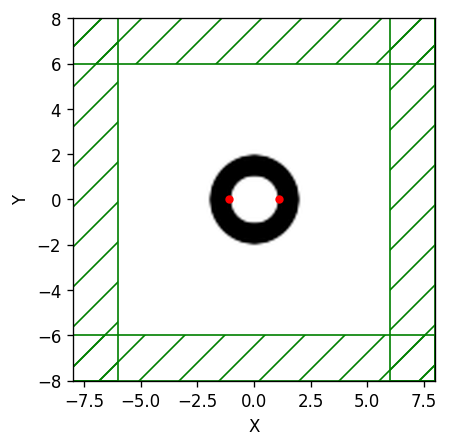

In [5]:
n = 3.4
w = 1
r = 1
pad = 4
dpml = 2

sxy = 2 * (r + w + pad + dpml)
cell_size = mp.Vector3(sxy, sxy)

pml_layers = [mp.PML(dpml)]

nonpml_vol = mp.Volume(mp.Vector3(), size=mp.Vector3(sxy - 2 * dpml, sxy - 2 * dpml))

geometry = [
    mp.Cylinder(radius=r + w, material=mp.Medium(index=n)),
    mp.Cylinder(radius=r),
]

fcen = 0.118

src = [
    mp.Source(mp.ContinuousSource(fcen), component=mp.Ez, center=mp.Vector3(r + 0.1)),
    mp.Source(
        mp.ContinuousSource(fcen),
        component=mp.Ez,
        center=mp.Vector3(-(r + 0.1)),
        amplitude=-1,
    ),
]

symmetries = [mp.Mirror(mp.X, phase=-1), mp.Mirror(mp.Y, phase=+1)]

sim = mp.Simulation(
    cell_size=cell_size,
    geometry=geometry,
    sources=src,
    resolution=10,
    force_complex_fields=True,
    symmetries=symmetries,
    boundary_layers=pml_layers,
)
f = plt.figure(dpi=120)
sim.plot2D(ax=f.gca())
plt.show()

In [ ]:
num_tols = 5
tols = np.power(10, np.arange(-8.0, -8.0 - num_tols, -1.0))
ez_dat = np.zeros((122, 122, num_tols), dtype=np.complex_)

for i in range(num_tols):
    sim.init_sim()
    sim.solve_cw(tols[i], 10000, 10)
    ez_dat[:, :, i] = sim.get_array(vol=nonpml_vol, component=mp.Ez)

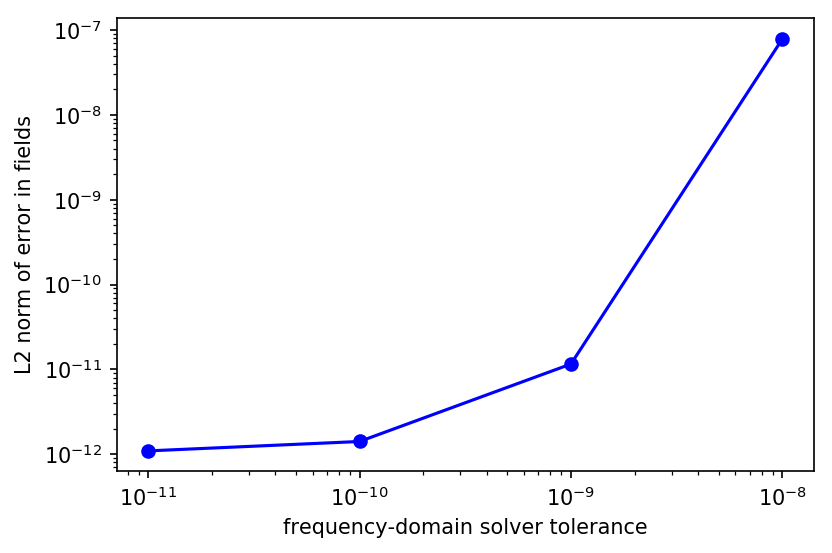

In [2]:
err_dat = np.zeros(num_tols - 1)
for i in range(num_tols - 1):
    err_dat[i] = LA.norm(ez_dat[:, :, i] - ez_dat[:, :, num_tols - 1])

plt.figure(dpi=150)
plt.loglog(tols[: num_tols - 1], err_dat, "bo-")
plt.xlabel("frequency-domain solver tolerance")
plt.ylabel("L2 norm of error in fields")
plt.show()

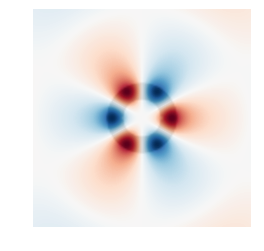

PASSED solve_cw test: error in the fields is decreasing with increasing resolution


In [3]:
eps_data = sim.get_array(vol=nonpml_vol, component=mp.Dielectric)
ez_data = np.real(ez_dat[:, :, num_tols - 1])

plt.figure()
plt.imshow(eps_data.transpose(), interpolation="spline36", cmap="binary")
plt.imshow(ez_data.transpose(), interpolation="spline36", cmap="RdBu", alpha=0.9)
plt.axis("off")
plt.show()

if np.all(np.diff(err_dat) < 0):
    print(
        "PASSED solve_cw test: error in the fields is decreasing with increasing resolution"
    )
else:
    print(
        "FAILED solve_cw test: error in the fields is NOT decreasing with increasing resolution"
    )

In [4]:
sim.reset_meep()

df = 0.08
src = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df), component=mp.Ez, center=mp.Vector3(r + 0.1)
    ),
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=mp.Vector3(-(r + 0.1)),
        amplitude=-1,
    ),
]

sim = mp.Simulation(
    cell_size=mp.Vector3(sxy, sxy),
    geometry=geometry,
    sources=src,
    resolution=10,
    symmetries=symmetries,
    boundary_layers=pml_layers,
)

dft_obj = sim.add_dft_fields([mp.Ez], fcen, 0, 1, where=nonpml_vol)

sim.run(until_after_sources=100)

-----------
Initializing structure...
run 0 finished at t = 225.0 (4500 timesteps)


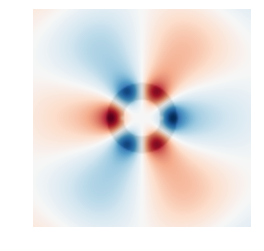

In [5]:
eps_data = sim.get_array(vol=nonpml_vol, component=mp.Dielectric)
ez_data = np.real(sim.get_dft_array(dft_obj, mp.Ez, 0))

plt.figure()
plt.imshow(eps_data.transpose(), interpolation="spline36", cmap="binary")
plt.imshow(ez_data.transpose(), interpolation="spline36", cmap="RdBu", alpha=0.9)
plt.axis("off")
plt.show()